<a href="https://colab.research.google.com/github/azhgh22/ML04_Facial_Expression_Recognition_Challenge/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 31.6 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 92% 262M/285M [00:03<00:00, 55.4MB/s]
100% 285M/285M [00:03<00:00, 92.9MB/s]


In [ ]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
! rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip

In [ ]:
! rm fer2013.tar.gz

In [ ]:
! rm icml_face_data.csv

**Imports**

In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


## **Slit data into Train(70%), Validation(15%), Test(15%)**

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
data.head(10)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,255 254 255 254 254 179 122 107 95 124 149 150...


In [ ]:
train=data.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [ ]:
data.shape

(28709, 2)

In [ ]:
train.shape

(20096, 2)

In [ ]:
train['emotion'].value_counts()

,count
emotion,
3,5035
6,3479
4,3402
2,2883
0,2811
5,2187
1,299


## **Custom DataSet class and Transformer**

In [ ]:
train['emotion']

,emotion
14538,3
25662,2
413,5
917,6
7130,3
...,...
14779,1
13190,0
16056,4
8977,4


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(np.array(dataframe['emotion'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        pixels = [int(x) for x in self.dataframe.iloc[idx, 1].split()]
        label = self.labels[idx]

        image = Image.fromarray(np.array(pixels,dtype=np.uint8).reshape(48, 48))

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [ ]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

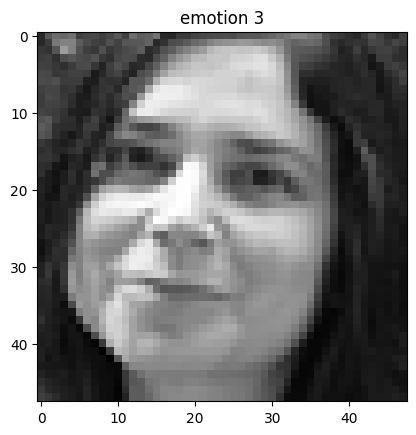

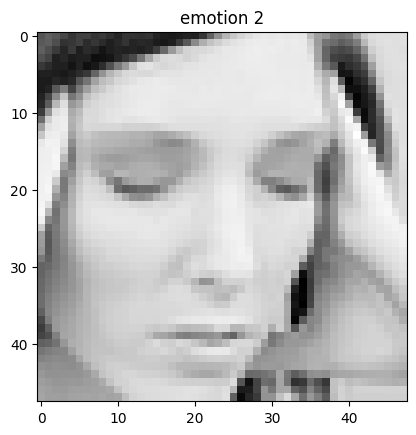

In [ ]:
for i in range(2):
  img, label = train_dataset[i]

  plt.imshow(img.squeeze().cpu().numpy(),cmap='gray')
  plt.title(f"emotion {label}")
  plt.show()

## **Hyperparameters**

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10
N_CLASSES = 7

# **Dataloaders**

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## **Model**

In [ ]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1) # First Convolution layer

      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((48 * 48 * 32), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, N_CLASSES) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)

      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)

## **Model Summary**

In [ ]:
from torchsummary import summary
summary(model, input_size = (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
           Flatten-3                [-1, 73728]               0
            Linear-4                  [-1, 128]       9,437,312
            Linear-5                    [-1, 7]             903
Total params: 9,438,535
Trainable params: 9,438,535
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.69
Params size (MB): 36.01
Estimated Total Size (MB): 37.70
----------------------------------------------------------------


## **Loss and Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

## **Training**

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 22.2675 Train Accuracy 30.9863
              Validation Loss: 4.3983 Validation Accuracy: 35.7641
Epoch 2/10, Train Loss: 19.6229 Train Accuracy 39.5601
              Validation Loss: 4.1745 Validation Accuracy: 40.5248
Epoch 3/10, Train Loss: 18.365 Train Accuracy 44.3571
              Validation Loss: 4.1058 Validation Accuracy: 41.8486
Epoch 4/10, Train Loss: 17.211 Train Accuracy 48.6664
              Validation Loss: 4.0633 Validation Accuracy: 41.686
Epoch 5/10, Train Loss: 16.0357 Train Accuracy 52.3786
              Validation Loss: 4.1668 Validation Accuracy: 41.1751
Epoch 6/10, Train Loss: 14.8729 Train Accuracy 56.1903
              Validation Loss: 4.1782 Validation Accuracy: 41.7325
Epoch 7/10, Train Loss: 13.7164 Train Accuracy 60.2807
              Validation Loss: 4.2355 Validation Accuracy: 43.3349
Epoch 8/10, Train Loss: 12.5638 Train Accuracy 63.9232
              Validation Loss: 4.2514 Validation Accuracy: 43.7993
Epoch 9/10, Train Loss: 11.

## **Testing**

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 41.4674 and Loss is 0.474


## **Plotting Training Progress**

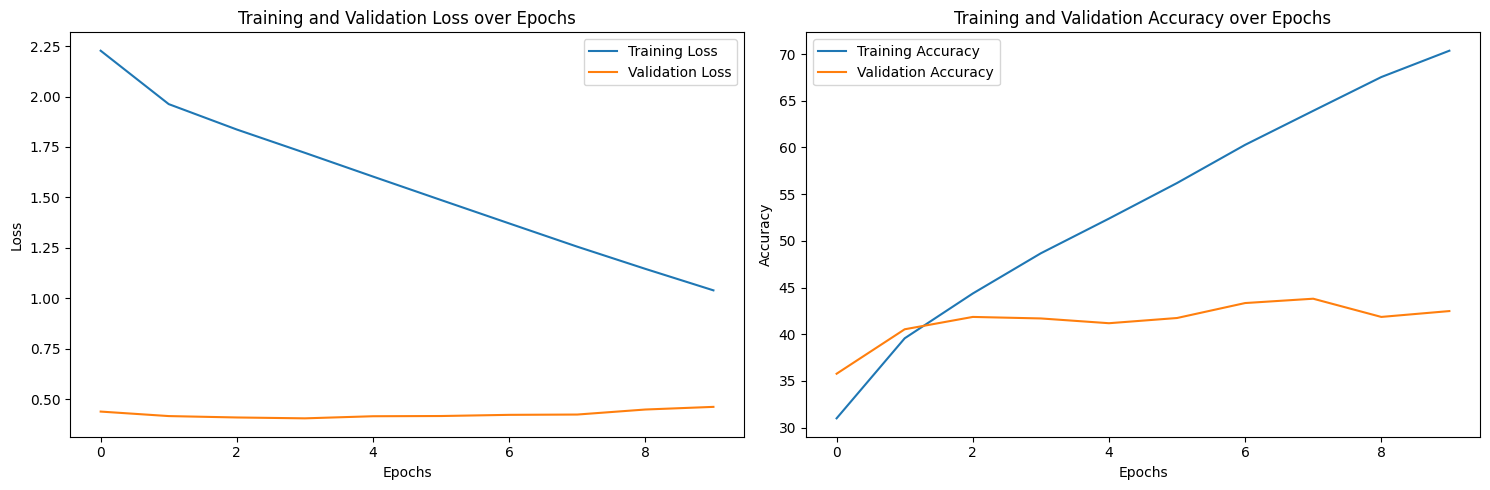

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()